## Introduction
In chemistry, **HOMO (Highest Occupied Molecular Orbital)** and **LUMO (Lowest Unoccupied Molecular Orbital)** are terms used to describe the `highest energy molecular orbital` at which electrons are present (HOMO) and the `lowest energy molecular orbital` that is unoccupied by electrons (LUMO). These orbitals play a crucial role in determining the `electronic properties` and `reactivity of chemical compounds`. The energy difference between the `HOMO` and `LUMO`, known as the **Homo-Lumo gap**, is a key factor in understanding the `stability`, `reactivity`, and `optical properties` of molecules. This project aims to use **machine learning algorithms** to predict **Homo-Lumo gaps** in chemicals compounds.

## Importing all the tools we need.

In [1]:
# Regular EDA (exploratory data analysis) and plotting libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lazypredict
import rdkit
import py3Dmol
import mols2grid
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, rdMolDescriptors, rdCoordGen
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
warnings.filterwarnings("ignore")
%matplotlib inline 

# ML models
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras import callbacks
from keras.layers import Dense, BatchNormalization, Dropout
from lazypredict.Supervised import LazyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

# Models for Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score, mean_absolute_error, mean_squared_error

### Load Data
This [dataset](https://www.kaggle.com/datasets/aideesis/small-compounds-molecular-orbitals-dataset/data) contains the **HOMO** and **LUMO** energies of **561** small  molecules, coupled with their `SMILES` and some of their `molecular descriptors`.

In [2]:
df = pd.read_csv("Result328_Descriptors.csv")
df.shape

(561, 32)

## Exploratory Data Analysis (EDA)

In [3]:
df.head()

,Number,num,Title,smiles,ho,lu,fermi,gap,molecular_weight,nonh_atoms,...,acrolein,has_N,amine,N_single_aromatic_carbon,aromatic_n,cyano,nitro,nitroso,has_N=O,acrylonitrile
0,170-01,1,Benzene,C1=CC=CC=C1,-7.04,-0.42,-3.73,6.62,78.05,6,...,False,False,False,False,False,False,False,False,False,False
1,170-02,2,Naph,C1=CC2=C(C=C1)C=CC=C2,-6.11,-1.37,-3.74,4.74,128.06,10,...,False,False,False,False,False,False,False,False,False,False
2,170-03,3,N4,C1=CC=C2C=C3C=C4C=CC=CC4=CC3=CC2=C1,-5.16,-2.43,-3.80,2.73,228.09,18,...,False,False,False,False,False,False,False,False,False,False
3,170-04,4,N8,C1=CC=C2C=C3C=C4C=C5C=C6C=C7C=C8C=CC=CC8=CC7=C...,-4.30,-3.43,-3.86,0.87,428.16,34,...,False,False,False,False,False,False,False,False,False,False
4,170-05,5,N16,C1=CC=C2C=C3C=C4C=C5C=C6C=C7C=C8C=C9C=C%10C=C%...,-4.25,-3.56,-3.90,0.69,828.28,66,...,False,False,False,False,False,False,False,False,False,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Number                    561 non-null    object 
 1   num                       561 non-null    int64  
 2   Title                     561 non-null    object 
 3   smiles                    561 non-null    object 
 4   ho                        561 non-null    float64
 5   lu                        561 non-null    float64
 6   fermi                     561 non-null    float64
 7   gap                       561 non-null    float64
 8   molecular_weight          561 non-null    float64
 9   nonh_atoms                561 non-null    int64  
 10  logp                      561 non-null    float64
 11  saturation                561 non-null    bool   
 12  aromatic                  561 non-null    bool   
 13  double_or_triple_bond     561 non-null    int64  
 14  small_ring

In [5]:
# Check for any missing values
df.isna().sum()

Number                      0
num                         0
Title                       0
smiles                      0
ho                          0
lu                          0
fermi                       0
gap                         0
molecular_weight            0
nonh_atoms                  0
logp                        0
saturation                  0
aromatic                    0
double_or_triple_bond       0
small_rings                 0
only_CH                     0
heteroatoms                 0
has_O                       0
O_single                    0
O_single_aromatic_carbon    0
O_double                    0
carbonyl                    0
acrolein                    0
has_N                       0
amine                       0
N_single_aromatic_carbon    0
aromatic_n                  0
cyano                       0
nitro                       0
nitroso                     0
has_N=O                     0
acrylonitrile               0
dtype: int64

### Calculation of molecular descriptors
For the compiled data, we will use the **RDKit python package** to calculate the `molecular descriptors` of the compounds.

In [6]:
def descriptors(smiles, verbose=False):

    des_list = [x[0] for x in Descriptors._descList]
    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        calculator = MoleculeDescriptors.MolecularDescriptorCalculator(des_list)
        row = np.array(calculator.CalcDescriptors(mol))

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames = des_list
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

df = pd.concat([df, descriptors(df['smiles'])], axis=1)

[13:47:15] WARNING: not removing hydrogen atom without neighbors
[13:47:15] DEPRECATION WARNING: please use MorganGenerator
[13:47:15] DEPRECATION WARNING: please use MorganGenerator
[13:47:15] DEPRECATION WARNING: please use MorganGenerator
[13:47:15] DEPRECATION WARNING: please use MorganGenerator
[13:47:15] DEPRECATION WARNING: please use MorganGenerator
[13:47:15] DEPRECATION WARNING: please use MorganGenerator
[13:47:15] DEPRECATION WARNING: please use MorganGenerator
[13:47:15] DEPRECATION WARNING: please use MorganGenerator
[13:47:15] DEPRECATION WARNING: please use MorganGenerator
[13:47:15] DEPRECATION WARNING: please use MorganGenerator
[13:47:15] DEPRECATION WARNING: please use MorganGenerator
[13:47:15] DEPRECATION WARNING: please use MorganGenerator
[13:47:15] DEPRECATION WARNING: please use MorganGenerator
[13:47:15] DEPRECATION WARNING: please use MorganGenerator
[13:47:15] DEPRECATION WARNING: please use MorganGenerator
[13:47:15] DEPRECATION WARNING: please use MorganG

Since we dont need the first three `columns`, we will remove them.

In [7]:
df = df.drop(['num', 'Title', 'Number'],axis=1)
df.head()

,smiles,ho,lu,fermi,gap,molecular_weight,nonh_atoms,logp,saturation,aromatic,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,C1=CC=CC=C1,-7.04,-0.42,-3.73,6.62,78.05,6,1.69,False,True,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,C1=CC2=C(C=C1)C=CC=C2,-6.11,-1.37,-3.74,4.74,128.06,10,2.84,False,True,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,C1=CC=C2C=C3C=C4C=CC=CC4=CC3=CC2=C1,-5.16,-2.43,-3.80,2.73,228.09,18,5.15,False,True,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,C1=CC=C2C=C3C=C4C=C5C=C6C=C7C=C8C=CC=CC8=CC7=C...,-4.30,-3.43,-3.86,0.87,428.16,34,9.76,False,True,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,C1=CC=C2C=C3C=C4C=C5C=C6C=C7C=C8C=C9C=C%10C=C%...,-4.25,-3.56,-3.90,0.69,828.28,66,18.98,False,True,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


We can use **RDKit** and **mols2grid** to visualise our chemicals.

In [8]:
# Visualising Chemicals
smiles_list = df['smiles'].to_list()
chems = [rdkit.Chem.MolFromSmiles(x) for x in smiles_list]
mols2grid.display(chems)

[13:47:21] WARNING: not removing hydrogen atom without neighbors


MolGridWidget()

And **Py3Dmol** to visualize their `3D structures`.

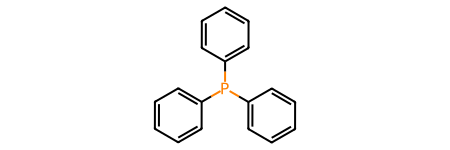

In [9]:
molecule = Chem.MolFromSmiles("c1ccc(P(c2ccccc2)c2ccccc2)cc1")
rdCoordGen.AddCoords(molecule)
molecule

In [10]:
def molecule_to_3d(molecule):
    mol = Chem.Mol(molecule)
    mol = AllChem.AddHs(mol, addCoords=True)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol)
    return mol

molecule_3d = molecule_to_3d(molecule)

In [11]:
view = py3Dmol.view(
    data=Chem.MolToMolBlock(molecule_3d),  # Convert the RDKit molecule for py3Dmol
    style={"stick": {}, "sphere": {"scale": 0.3}}
)
view.zoomTo()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Bond types

In [12]:
# Create a function that plots the frequency of various Bond types.
def bond_frequency(smiles_list):
    
    bond_counts = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        bonds = mol.GetBonds()
        # Loop through each bond in the molecule and append its bond type to the bond_counts list
        bond_counts.extend([bond.GetBondTypeAsDouble() for bond in bonds])

    # Create a pandas series with the counts of each bond type
    plot_data = pd.Series(bond_counts).value_counts().sort_index()
    plt.figure(figsize = (8,8))
    plt.pie(plot_data.values, labels=plot_data.index, colors=sns.color_palette("plasma_r"), autopct='%1.1f%%', textprops={'fontsize': 12});

[13:47:21] WARNING: not removing hydrogen atom without neighbors


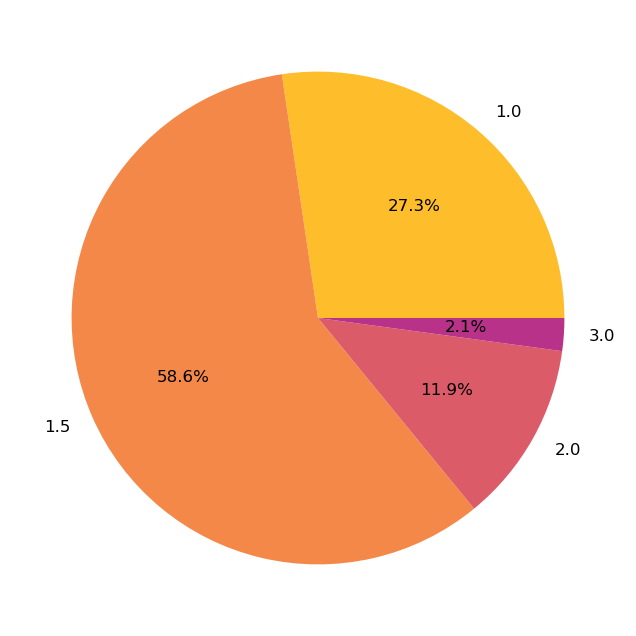

In [13]:
bond_frequency(df['smiles'])

## Distribution of Homo-Lumo gaps
The `sub-distributions` of **HOMO-LUMO gaps** are predominantly influenced by the presence of functional groups like `aromatic rings` and `carbonyl groups`, We can exploit this behavior in our **regression models**.

### Saturated vs Unsaturated

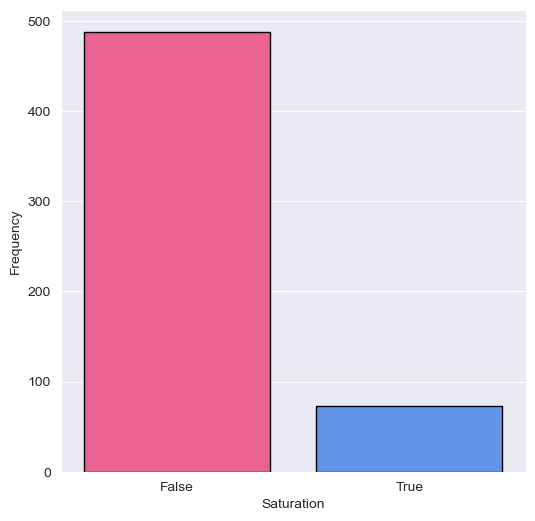

In [14]:
#Choose a style for the plot
sns.set_style("darkgrid")

plt.subplots(figsize=(6, 6))
palette = ["#ff4c8b", "#4c8eff"]
sns.countplot(x='saturation', data=df, order = df['saturation'].value_counts().index, palette=palette, edgecolor='black')
plt.xlabel('Saturation')
plt.ylabel('Frequency');

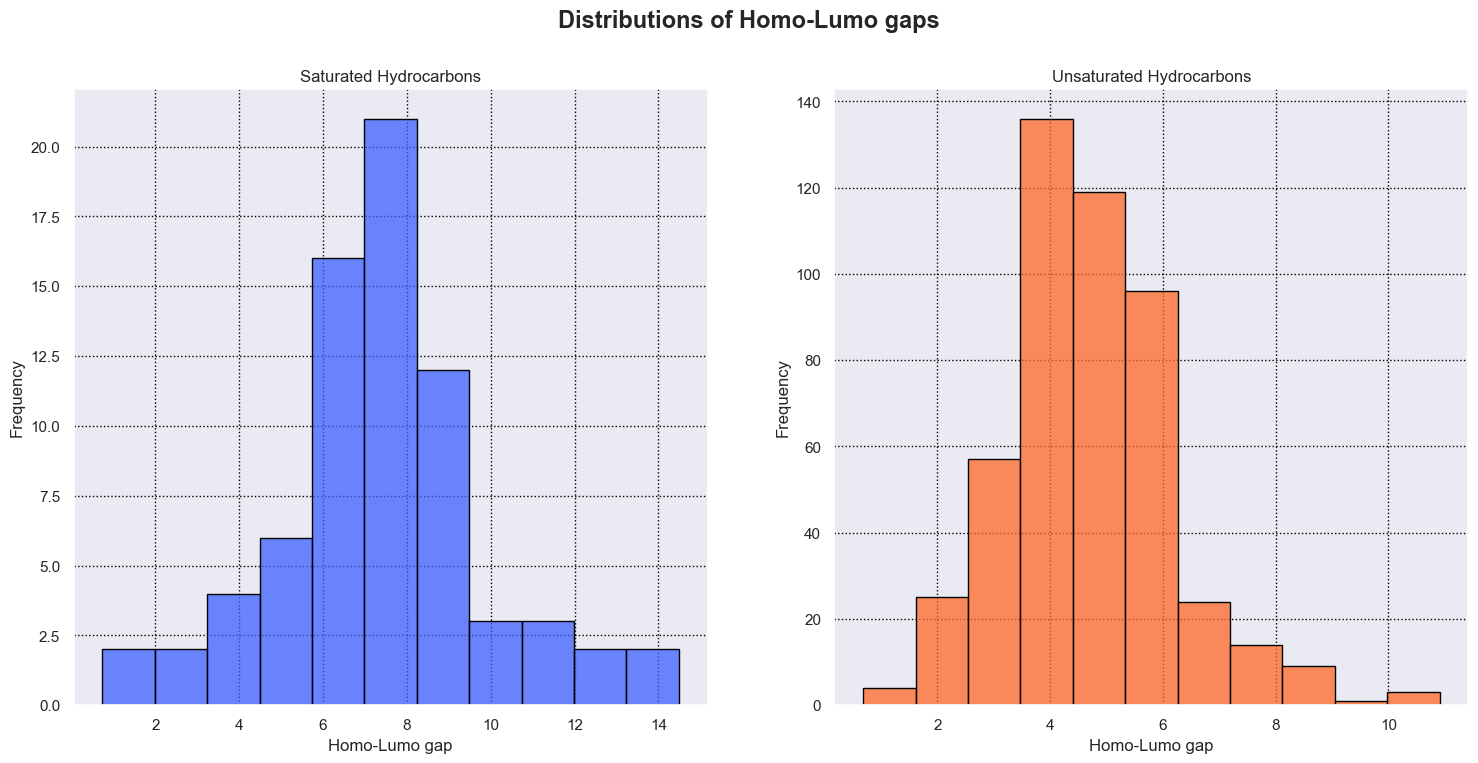

In [15]:
#Choose a style for the plot
sns.set_style("darkgrid", {"grid.color": "black", "grid.linestyle": ":"})
sns.set_context("notebook")

# Create a figure and axes with 1 row and 2 columns
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Visualising the distribution of Saturated Hydrocarbons
sns.histplot(data=df.loc[df['saturation'] == True], x='gap', color='#3d61ff', edgecolor='black', bins=11, ax=ax[0])
ax[0].set_title('Saturated Hydrocarbons')
ax[0].set_xlabel('Homo-Lumo gap')
ax[0].set_ylabel('Frequency');

# Visualising the distribution of Unsaturated Hydrocarbons
sns.histplot(data=df.loc[df['saturation'] == False], x='gap', color='#ff6928', edgecolor='black', bins=11, ax=ax[1])
ax[1].set_title('Unsaturated Hydrocarbons')
ax[1].set_xlabel('Homo-Lumo gap')
ax[1].set_ylabel('Frequency');

fig.suptitle("Distributions of Homo-Lumo gaps", fontsize=17, fontweight="bold");

### Aromatic vs Nonaromatic

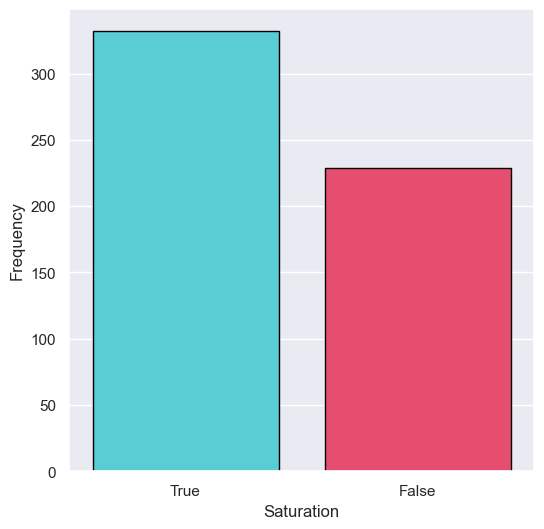

In [16]:
#Choose a style for the plot
sns.set_style("darkgrid")

plt.subplots(figsize=(6, 6))
palette = ["#45dfe7", "#ff3561"]
sns.countplot(x='aromatic', data=df, order = df['aromatic'].value_counts().index, palette=palette, edgecolor='black')
plt.xlabel('Saturation')
plt.ylabel('Frequency');

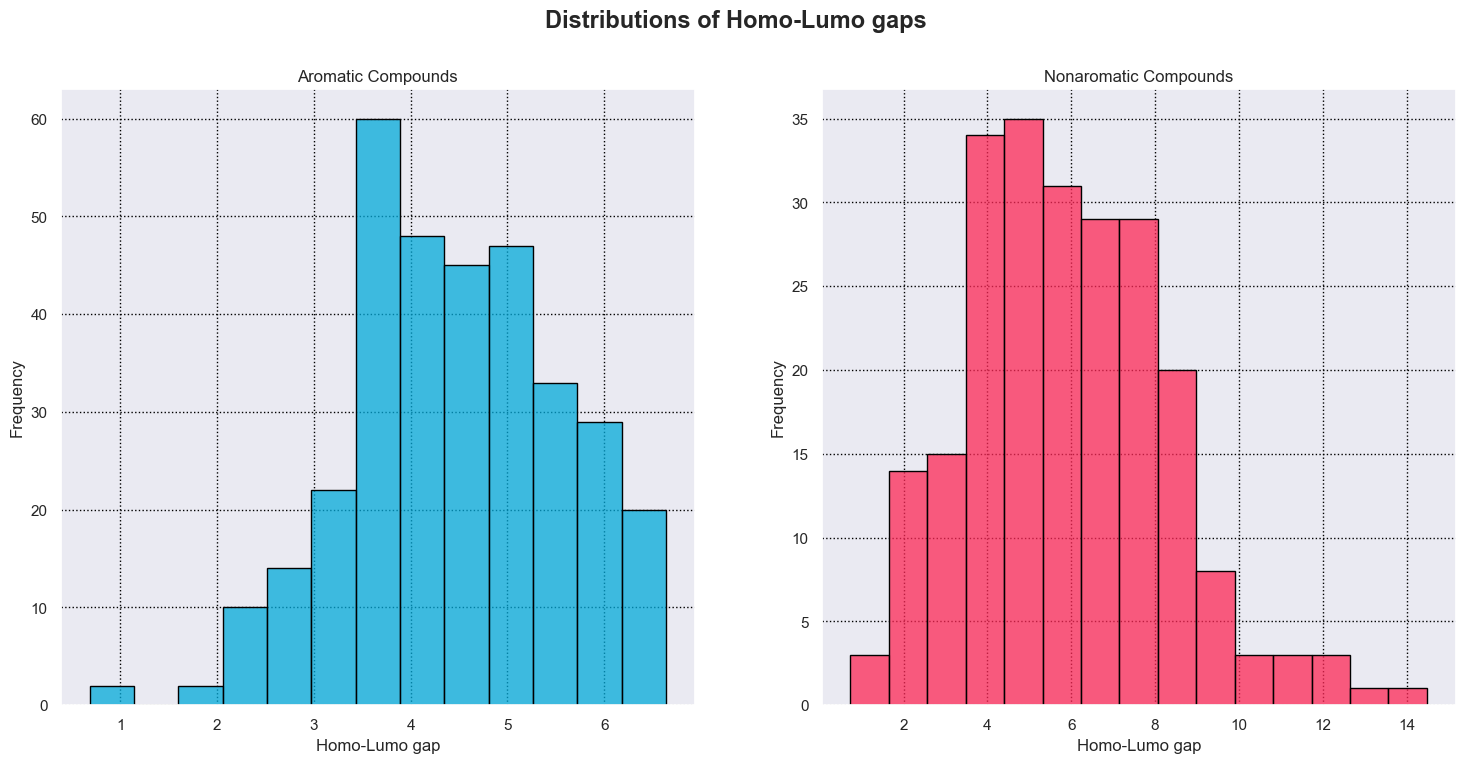

In [17]:
#Choose a style for the plot
sns.set_style("darkgrid", {"grid.color": "black", "grid.linestyle": ":"})
sns.set_context("notebook")

# Create a figure and axes with 1 row and 2 columns
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Visualising the distribution of Aromatic Compounds
sns.histplot(data=df.loc[df['aromatic'] == True], x='gap', color='#03aad9', edgecolor='black', bins=13, ax=ax[0])
ax[0].set_title('Aromatic Compounds')
ax[0].set_xlabel('Homo-Lumo gap')
ax[0].set_ylabel('Frequency');

# Visualising the distribution of Nonaromatic Compounds
sns.histplot(data=df.loc[df['aromatic'] == False], x='gap', color='#fd2856', edgecolor='black', bins=15, ax=ax[1])
ax[1].set_title('Nonaromatic Compounds')
ax[1].set_xlabel('Homo-Lumo gap')
ax[1].set_ylabel('Frequency');

fig.suptitle("Distributions of Homo-Lumo gaps", fontsize=17, fontweight="bold");

Looking at the `distributions` it appears that the more unsaturated a molecule is, the lower its **HOMO–LUMO gap** will be, with `aromatic` and `fully saturated` molecules having the smallest and largest gaps, respectively. This is to be expected since in unsaturated molecules, the `frontier orbitals` are often **π-orbitals**, which are closer in energy.

### Molecular Weight vs Homo-Lumo gap

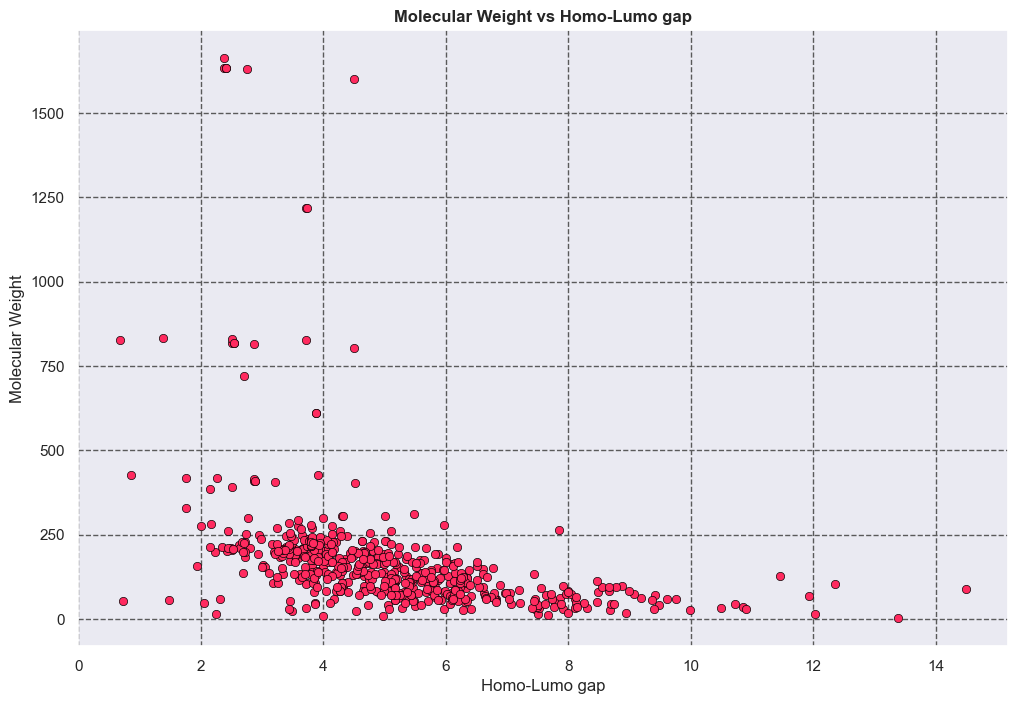

In [18]:
#Choose a style for the plot
sns.set_style("darkgrid", {"grid.color": "#5a5a5a", "grid.linestyle": "--"})
sns.set_context("notebook")

plt.figure(figsize=(12,8))
sns.scatterplot(data=df, x='gap', y='molecular_weight', color='#ff2a5f', edgecolor='black')
plt.title('Molecular Weight vs Homo-Lumo gap', fontweight="bold")
plt.xlabel('Homo-Lumo gap')
plt.ylabel('Molecular Weight');

## Feature Selection
**feature selection** helps to identify the most important `features` in a dataset and remove the `noise` or `irrelevant information`. This procedure can help to reduce the `dimensionality` of datasets, as **high-dimensional datasets** can lead to `overfitting` and `poor performance` of **machine learning models**.

In [19]:
# Setup random seed
np.random.seed(50)

# Spliting data into X and y
X = df.drop(['gap', 'ho', 'lu', 'fermi', 'smiles'],axis=1)
y = df['gap']

# Split data into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Remove duplicate columns

In [20]:
def get_duplicate_columns(df):
    
    duplicate_columns = {}
    seen_columns = {}

    for column in df.columns:
        current_column = df[column]

        # Convert column data to bytes
        try:
            current_column_hash = current_column.values.tobytes()
        except AttributeError:
            current_column_hash = current_column.to_string().encode()

        if current_column_hash in seen_columns:
            if seen_columns[current_column_hash] in duplicate_columns:
                duplicate_columns[seen_columns[current_column_hash]].append(column)
            else:
                duplicate_columns[seen_columns[current_column_hash]] = [column]
        else:
            seen_columns[current_column_hash] = column

    return duplicate_columns

In [21]:
duplicate_columns = get_duplicate_columns(X_train)
for one_list in duplicate_columns.values():
    X_train.drop(columns=one_list,inplace=True)
    X_test.drop(columns=one_list,inplace=True)

X_train.shape

(448, 199)

### Variance threshold
**Variance threshold** is a `filter-based` feature selection method used to remove `low-variance features` from a dataset. The basic idea behind this method is that `features` with `low variance` are not useful in predicting the `target variable` and can be safely `removed` from the dataset.

In [22]:
sel = VarianceThreshold(threshold=0.17)
sel.fit(X_train)

VarianceThreshold(threshold=0.17)

In [23]:
columns = X_train.columns[sel.get_support()]

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train = pd.DataFrame(X_train, columns=columns)
X_test = pd.DataFrame(X_test, columns=columns)

X_train.shape

(448, 130)

### ANOVA F-test
**Analysis of variance (ANOVA)** is used to determine if there are `statistically significant differences` between the means of three or more `independent groups`. It essentially uses the **F-test** to compare the overall `variation` between the group means to the `variation` within the groups. If the **F-statistic** from the **ANOVA** is large enough, it suggests that at least one group `mean` is `significantly different` from the others, then that group is considered to be overall more `informative` and hence `selected`.

In [24]:
X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
X_test = X_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [25]:
sel = SelectKBest(f_classif, k=42).fit(X_train, y_train)

# display selected feature names
X_train.columns[sel.get_support()]

Index(['molecular_weight', 'nonh_atoms', 'logp', 'double_or_triple_bond',
       'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons',
       'BCUT2D_MWLOW', 'BCUT2D_LOGPHI', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v',
       'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n',
       'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3',
       'LabuteASA', 'PEOE_VSA12', 'PEOE_VSA6', 'SMR_VSA7', 'SMR_VSA9',
       'EState_VSA4', 'EState_VSA8', 'VSA_EState5', 'HeavyAtomCount',
       'NumRotatableBonds', 'RingCount', 'MolLogP', 'MolMR'],
      dtype='object')

In [26]:
columns = X_train.columns[sel.get_support()]

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train = pd.DataFrame(X_train, columns=columns).drop(['MolWt', 'logp', 'molecular_weight', 'HeavyAtomMolWt'],axis=1)
X_test = pd.DataFrame(X_test, columns=columns).drop(['MolWt', 'logp', 'molecular_weight', 'HeavyAtomMolWt'],axis=1)

Now that we've selected our `features`, we'll look at their `correlation matrix`.

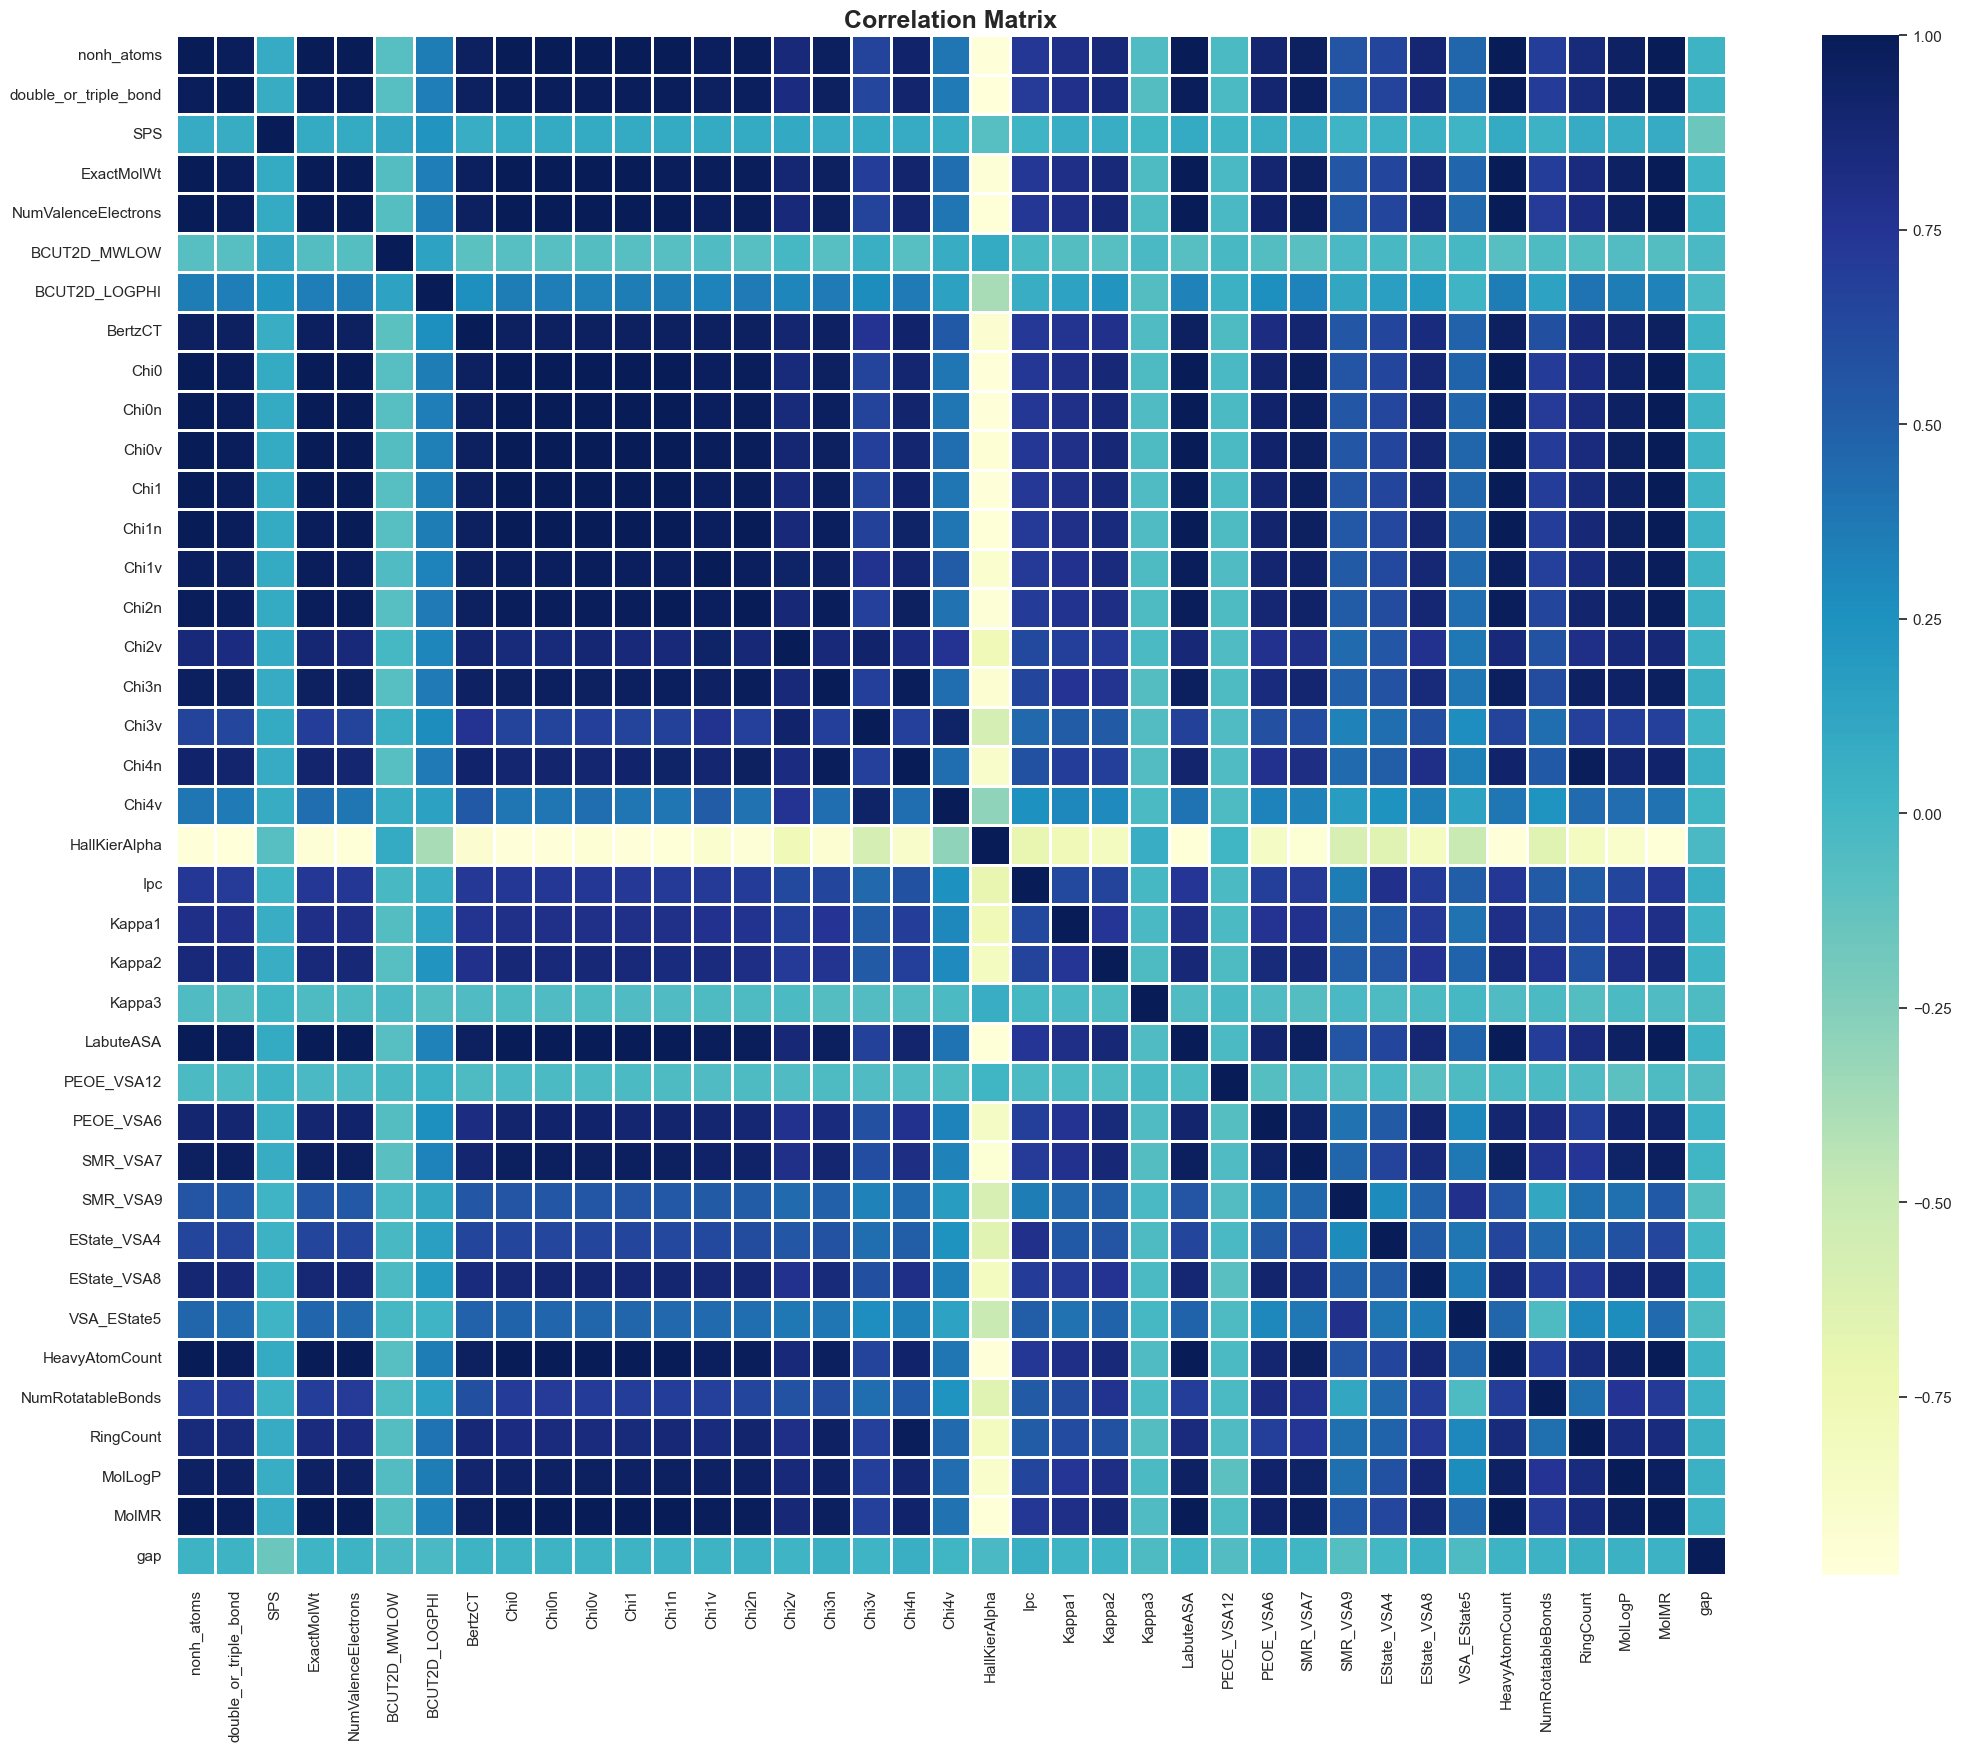

In [27]:
# Making our correlation matrix
df_col_merged = pd.concat([X_train, y_train], axis=1)
corr_matrix = df_col_merged.corr()
fig, ax = plt.subplots(figsize=(25, 20))
ax = sns.heatmap(corr_matrix,
                 annot=False, 
                 linewidths=1,
                 cmap="YlGnBu");
plt.title('Correlation Matrix',fontsize=18, fontweight="bold");

## Machine Learning

In [28]:
# Setup random seed
np.random.seed(50)

# Using lazypredict to run through different models
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

 79%|████████████████████████████████████████████████████████████████▍                 | 33/42 [00:04<00:00, 13.45it/s]

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.38it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3730
[LightGBM] [Info] Number of data points in the train set: 448, number of used features: 37
[LightGBM] [Info] Start training from score 5.054076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [29]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
XGBRegressor,0.65,0.77,0.78,0.23
ExtraTreesRegressor,0.62,0.75,0.82,0.84
BaggingRegressor,0.60,0.74,0.83,0.21
RandomForestRegressor,0.59,0.73,0.84,1.96
GradientBoostingRegressor,0.56,0.71,0.87,0.75
LGBMRegressor,0.49,0.66,0.95,0.07
HistGradientBoostingRegressor,0.45,0.64,0.98,0.39
AdaBoostRegressor,0.28,0.52,1.12,0.19
LinearRegression,0.25,0.50,1.15,0.01


Lets try to tune `hyperparameters` for some of the better performing `models`.

### Hyperparameter tuning with RandomizedSearchCV
In **Machine Learning**, multiple `hyperparameters` are used to `maximize` the input model’s performance and `generalization ability`. These parameters are not learned from the `training data` but are selected before training the `model`. These parameters can include the number of `epochs`, the number of `hidden layers` in the **neural network**, the number of `trees`, `tree depth` in **random forests**, etc. What **RandomizedSearchCV** does is search for the best `hyperparameter combination` within the predefined distributions that gives the best score as an output.

In [30]:
def evaluate_preds(y_true, y_preds):
    
    R2 = r2_score(y_true, y_preds)
    RMSE = mean_squared_error(y_true, y_preds, squared=False)
    MAE = mean_absolute_error(y_true, y_preds)
    
    metric_dict = {"R2": round(R2, 2),
                   "RMSE": round(RMSE, 2),
                   "MAE": round(MAE, 2)}
    
    print(f"R2 score: {R2:.2f}")
    print(f"RMSE: {RMSE:.2f}")
    print(f"MAE: {MAE:.2f}")
    
    return metric_dict

In [31]:
# Setup random seed
np.random.seed(50)

et_reg = ExtraTreesRegressor()
et_reg.fit(X_train, y_train)
y_preds = et_reg.predict(X_test)
evaluate_preds(y_test,y_preds);

R2 score: 0.74
RMSE: 0.83
MAE: 0.56


In [32]:
# Create a hyperparameter grid for ExtraTreesRegressor
et_reg_grid = {'n_estimators': [100,200,400,800],
    'max_depth': [2,7,15,35,50],
    'oob_score': [True, False],    
    'bootstrap': [True, False],
    'criterion': ['squared_error', 'absolute_error']}

# Setup random seed
np.random.seed(50)

# Setup RandomizedSearchCV for ExtraTreesRegressor
gs_et_reg = RandomizedSearchCV(ExtraTreesRegressor(),
                          param_distributions=et_reg_grid,
                          cv=5,
                          verbose=True,
                          n_iter=36,
                          n_jobs = -1)

# Fit RandomizedSearchCV for ExtraTreesRegressor
gs_et_reg.fit(X_train, y_train);
y_preds = gs_et_reg.predict(X_test);
evaluate_preds(y_test,y_preds);

Fitting 5 folds for each of 36 candidates, totalling 180 fits
R2 score: 0.75
RMSE: 0.81
MAE: 0.55


In [33]:
# Setup random seed
np.random.seed(50)

rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
y_preds = rf_reg.predict(X_test)
evaluate_preds(y_test,y_preds);

R2 score: 0.74
RMSE: 0.84
MAE: 0.57


In [34]:
# Create a hyperparameter grid for RandomForestRegressor
rf_reg_grid = {'n_estimators': [100,300,400],
    'max_depth': [4,8,16,33,55],    
    'bootstrap': [True, False],
    'criterion': ['squared_error', 'absolute_error']}

# Setup random seed
np.random.seed(50)

# Setup RandomizedSearchCV for RandomForestRegressor
gs_rf_reg = RandomizedSearchCV(RandomForestRegressor(),
                          param_distributions=rf_reg_grid,
                          cv=5,
                          verbose=True,
                          n_iter=26,
                          n_jobs = -1)

# Fit RandomizedSearchCV for RandomForestRegressor
gs_rf_reg.fit(X_train, y_train);
y_preds = gs_rf_reg.predict(X_test);
evaluate_preds(y_test,y_preds);

Fitting 5 folds for each of 26 candidates, totalling 130 fits
R2 score: 0.75
RMSE: 0.82
MAE: 0.55


### Deep learning
Lets try using **neuron network** to see if it can do better job then the other `algorithms` we have tested so far.

In [35]:
# Setup random seed
np.random.seed(50)

# Spliting data into X and y
X = df.drop(['gap', 'ho', 'lu', 'fermi', 'smiles'],axis=1)
y = df['gap']

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
X_test = X_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

#Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [36]:
# Initialising the NN
model = Sequential()

# layers
model.add(Dense(64, activation = 'relu', input_dim = 234))
model.add(Dropout(rate=0.1)) 
model.add(BatchNormalization())

model.add(Dense(16, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))

model.add(Dense(1))

# Compiling the NN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │          15,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,625 (64.94 KB)

 Trainable params: 16,497 (64.44 KB)

 Non-trainable params: 128 (512.00 B)

In [37]:
# Setup random seed
np.random.seed(50)

# Train the NN
history = model.fit(X_train, y_train, batch_size = 150, epochs = 300, validation_split=0.2)

Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 28.9194 - val_loss: 26.1644
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 24.3312 - val_loss: 24.3268
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 21.2398 - val_loss: 22.4483
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 20.4596 - val_loss: 20.4597
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 18.6732 - val_loss: 18.3990
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 16.1957 - val_loss: 16.2944
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 14.6844 - val_loss: 14.2197
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 12.2458 - val_loss: 12.2565
Epoch 9/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 10.3422 - val_loss: 10.5351
Epoch 10/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.1073 - val_loss: 9.0447
Epoch 11/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.2657 - val_loss: 7.8345
Epoch 12/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - los

In [38]:
def training_history(model):
    train_loss = model.history['loss']
    val_loss = model.history['val_loss']
    epochs = range(1, len(train_loss) + 1)

    #Choose a style for the plot
    plt.style.use("default")

    # Create a figure and axes with 1 row and 2 columns
    plt.figure(figsize=(9, 6))

    plt.plot(epochs, train_loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend();

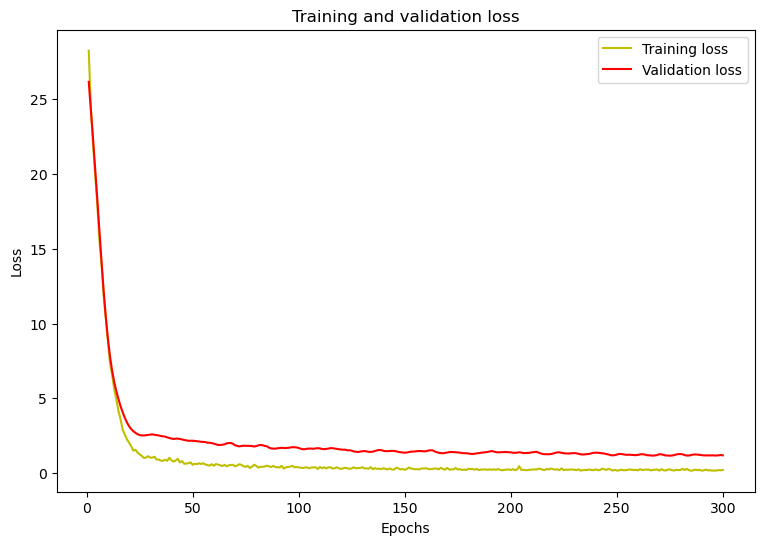

In [39]:
training_history(history)

In [40]:
# Predicting the test set results
y_preds = model.predict(X_test)

evaluate_preds(y_test, y_preds);

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R2 score: 0.50
RMSE: 1.15
MAE: 0.77


looks like the **neural network**  is not performing all that well.

### 10-Fold Cross Validation Metrics
**K-Fold Cross Validation** is a technique used in **machine learning** to assess the `performance` of a **predictive model**. It involves splitting the dataset into `k subsets`, or `folds`, and then training the model `k times`, each time using a different `fold` as the `validation set` and the remaining `folds` as the `training set`. This helps to ensure that the `model's performance` is not overly dependent on a particular subset of the data. The results from each iteration are then averaged to provide a more `reliable` estimate of the `model's performance`.

In [41]:
def cv_evaluate_preds(model, X, y):
    
    R2 = cross_val_score(model, X, y, cv=10, scoring='r2').mean()
    RMSE = np.abs(cross_val_score(model, X, y, cv=10, scoring='neg_root_mean_squared_error').mean())
    MAE = np.abs(cross_val_score(model, X, y, cv=10, scoring='neg_mean_absolute_error').mean())
    
    metric_dict = {"R2": round(R2, 2),
                   "RMSE": round(RMSE, 2),
                   "MAE": round(MAE, 2)}
    
    print(f"R2 score: {R2:.2f}")
    print(f"RMSE: {RMSE:.2f}")
    print(f"MAE: {MAE:.2f}")
    
    return metric_dict

In [42]:
# Setup random seed
np.random.seed(50)

# Spliting data into X and y
X = df.drop(['gap', 'ho', 'lu', 'fermi', 'smiles'],axis=1)
y = df['gap']

# Splitting the dataset into the Training set and Test set
X = X[columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
X_test = X_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [43]:
# Setup random seed
np.random.seed(50)

et_reg = ExtraTreesRegressor()
et_reg = et_reg.set_params(**gs_et_reg.best_params_).fit(X_train, y_train)
y_preds_gap = et_reg.predict(X_test)
cv_evaluate_preds(et_reg, X_train, y_train);

R2 score: 0.70
RMSE: 1.03
MAE: 0.63


### Feature Importance
**Feature importance** in `machine learning` refers to identifying which `input features` have the most impact on predicting the `target variable`. It helps in understanding the key factors influencing the model's predictions.

In [44]:
# Function for plotting feature importance
def plot_features(columns, importances, n=25):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots(figsize=(11, 8))
    ax.barh(df["features"][:n], df["feature_importances"][:25], color="royalblue", edgecolor='black')
    ax.set_title('Feature importance', fontsize=14, fontweight="bold")
    ax.invert_yaxis()

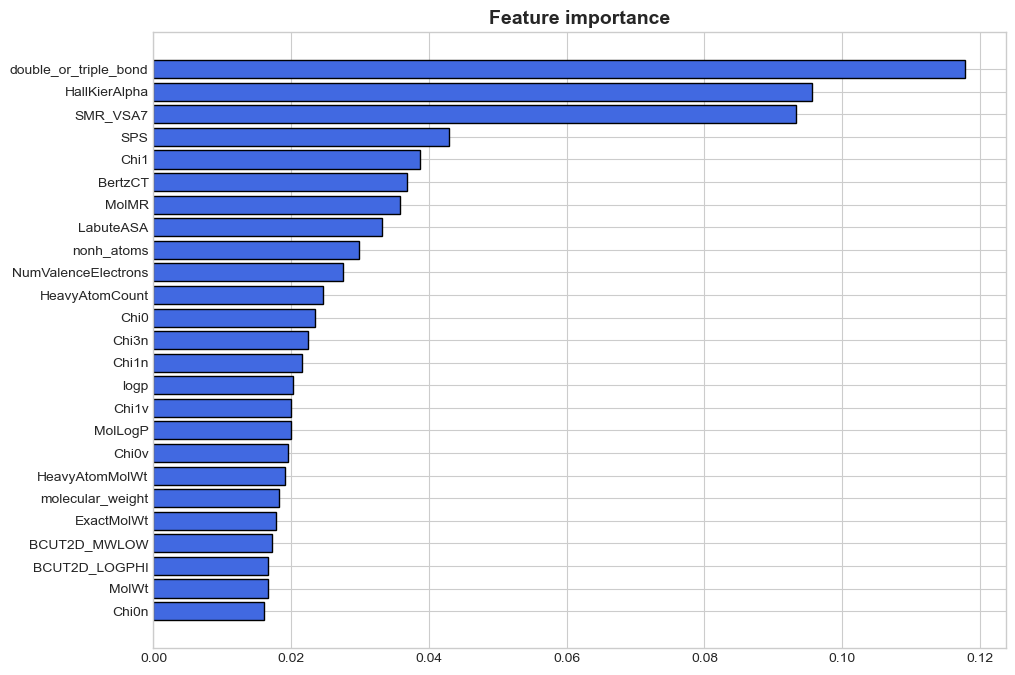

In [45]:
plt.style.use("seaborn-v0_8-whitegrid")
plot_features(X_train.columns, et_reg.feature_importances_)

### Calculated vs Predicted
Once appropriate `parameters` have been selected for our model, the next step involves utilizing the model to predict the **HOMO** and **LUMO** orbital energies separately. Subsequently, we will calculate the **HOMO-LUMO gap** and proceed to compare these calculated values with those directly predicted by the model.

In [46]:
# Setup random seed
np.random.seed(50)

et_reg = ExtraTreesRegressor()
et_reg = et_reg.set_params(**gs_et_reg.best_params_).fit(X_train, y_train)
y_preds_gap = et_reg.predict(X_test)
evaluate_preds(y_test,y_preds_gap);

R2 score: 0.74
RMSE: 0.83
MAE: 0.56


Predicting the **HOMO**

In [47]:
# Setup random seed
np.random.seed(50)

# Spliting data into X and y
X = df.drop(['gap', 'ho', 'lu', 'fermi', 'smiles'],axis=1)
y = df['ho']

# Split data into train & test set
X = X[columns]
X_train_ho, X_test_ho, y_train_ho, y_test_ho = train_test_split(X, y, test_size=0.2)

et_reg = ExtraTreesRegressor().set_params(**gs_et_reg.best_params_).fit(X_train, y_train_ho)
y_preds_ho = et_reg.predict(X_test)

Predicting the **LUMO**

In [48]:
# Setup random seed
np.random.seed(50)

# Spliting data into X and y
X = df.drop(['gap', 'ho', 'lu', 'fermi', 'smiles'],axis=1)
y = df['lu']

# Split data into train & test set
X = X[columns]
X_train_lu, X_test_lu, y_train_lu, y_test_lu = train_test_split(X, y, test_size=0.2)

et_reg = ExtraTreesRegressor().set_params(**gs_et_reg.best_params_).fit(X_train, y_train_lu)
y_preds_lu = et_reg.predict(X_test)

Calculated vs Predicted

In [49]:
evaluate_preds(y_test,y_preds_lu-y_preds_ho);

R2 score: 0.71
RMSE: 0.87
MAE: 0.59


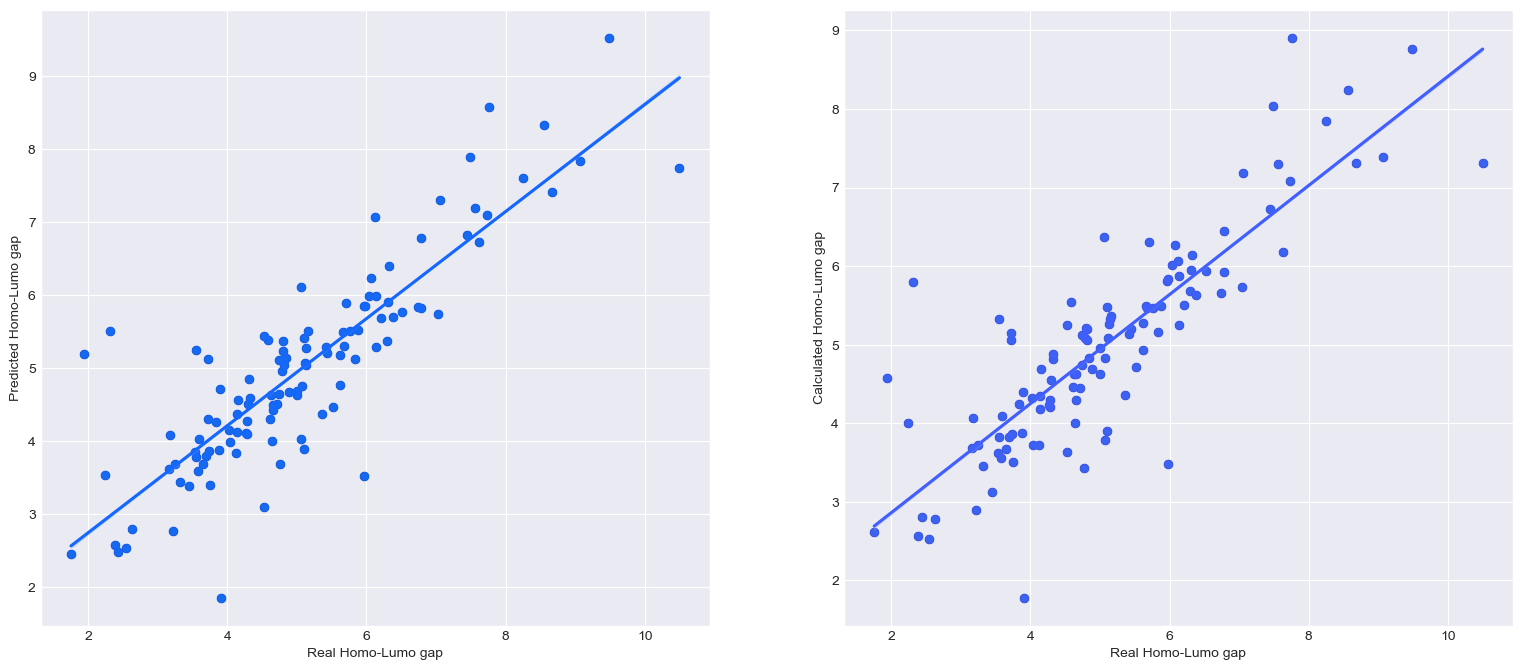

In [50]:
#Choose a style for the plot
sns.set_style("darkgrid")

# Create a figure and axes with 1 row and 2 columns
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(19, 8))
dataset = pd.DataFrame({'Actual': y_test, 'Lumo-Homo': y_preds_lu-y_preds_ho, 'Gap': list(y_preds_gap)}, columns=['Actual', 'Lumo-Homo', 'Gap'])

sns.scatterplot(data=dataset, x='Actual', y='Gap', edgecolor='black', ax=ax[0])
sns.regplot(data=dataset, x='Actual', y='Gap', ci=10, ax=ax[0], color='#1567ff')
ax[0].set_xlabel('Real Homo-Lumo gap')
ax[0].set_ylabel('Predicted Homo-Lumo gap');

sns.scatterplot(data=dataset, x='Actual', y='Lumo-Homo', edgecolor='black', ax=ax[1])
sns.regplot(data=dataset, x='Actual', y='Lumo-Homo', ci=10, ax=ax[1], color='#415eff')
ax[1].set_xlabel('Real Homo-Lumo gap')
ax[1].set_ylabel('Calculated Homo-Lumo gap');

## Classes of molecules
We will use our **regression model** on different `classes` of chemicals to see how well it performs on them.

### Aromatic Carbonyl Compounds

In [51]:
chem_class = df.loc[df['aromatic'] == True].loc[df['carbonyl'] == True]
chem_class.shape

(77, 239)

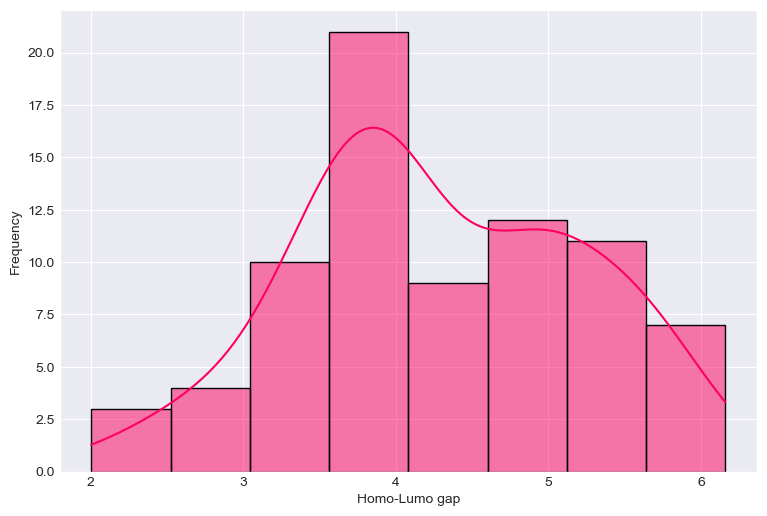

In [52]:
#Choose a style for the plot
sns.set_style('darkgrid')

# Visualize distribution
plt.figure(figsize=(9,6))
sns.histplot(data=chem_class, x='gap', color='#FF005E', edgecolor='black', bins=8, kde=True)
plt.xlabel('Homo-Lumo gap')
plt.ylabel('Frequency');

In [53]:
# Setup random seed
np.random.seed(50)

# Spliting data into X and y
X = df.drop(['gap', 'ho', 'lu', 'fermi', 'smiles'],axis=1).loc[df['aromatic'] == True].loc[df['carbonyl'] == True]
y = df['gap'].loc[df['aromatic'] == True].loc[df['carbonyl'] == True]

# Split data into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [54]:
# Setup random seed
np.random.seed(50)

et_reg = ExtraTreesRegressor()
et_reg = et_reg.set_params(**gs_et_reg.best_params_).fit(X_train, y_train)
y_preds_gap = et_reg.predict(X_test)
evaluate_preds(y_test,y_preds_gap);

R2 score: 0.78
RMSE: 0.40
MAE: 0.30


### Unsaturated Carbonyl Compounds

In [55]:
chem_class = df.loc[df['saturation'] == False].loc[df['carbonyl'] == True]
chem_class.shape

(160, 239)

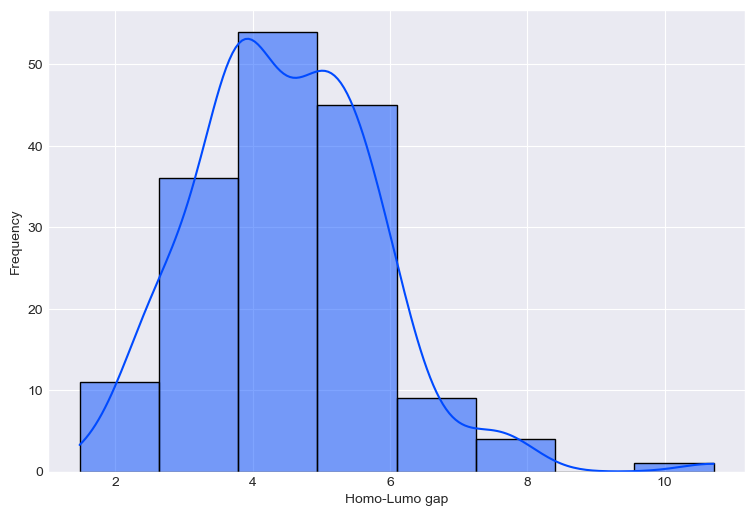

In [56]:
#Choose a style for the plot
sns.set_style('darkgrid')

# Visualize distribution
plt.figure(figsize=(9,6))
sns.histplot(data=chem_class, x='gap', color='#004aff', edgecolor='black', bins=8, kde=True)
plt.xlabel('Homo-Lumo gap')
plt.ylabel('Frequency');

In [57]:
# Setup random seed
np.random.seed(50)

# Spliting data into X and y
X = df.drop(['gap', 'ho', 'lu', 'fermi', 'smiles'],axis=1).loc[df['saturation'] == False].loc[df['carbonyl'] == True]
y = df['gap'].loc[df['saturation'] == False].loc[df['carbonyl'] == True]

# Split data into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [58]:
# Setup random seed
np.random.seed(50)

et_reg = ExtraTreesRegressor()
et_reg = et_reg.set_params(**gs_et_reg.best_params_).fit(X_train, y_train)
y_preds_gap = et_reg.predict(X_test)
evaluate_preds(y_test,y_preds_gap);

R2 score: 0.89
RMSE: 0.40
MAE: 0.20


### Non Aromatic Compounds

In [59]:
chem_class = df.loc[df['aromatic'] == False]
chem_class.shape

(229, 239)

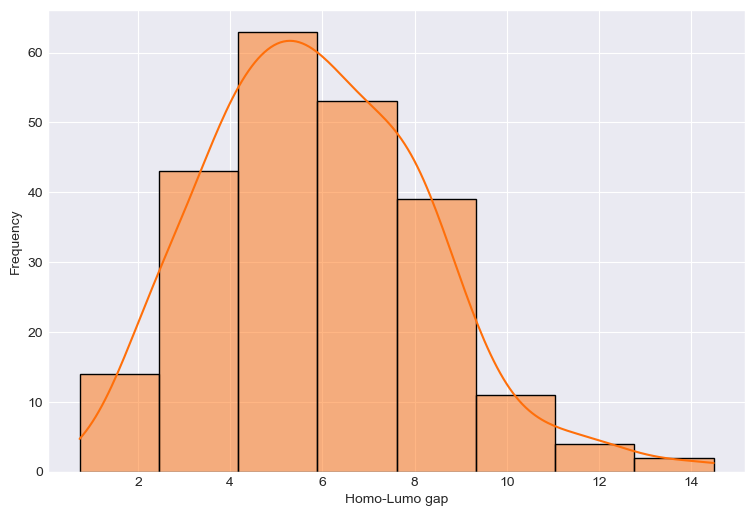

In [60]:
#Choose a style for the plot
sns.set_style('darkgrid')

# Visualize distribution
plt.figure(figsize=(9,6))
sns.histplot(data=chem_class, x='gap', color='#ff6f0a', edgecolor='black', bins=8, kde=True)
plt.xlabel('Homo-Lumo gap')
plt.ylabel('Frequency');

In [61]:
# Setup random seed
np.random.seed(50)

# Spliting data into X and y
X = df.drop(['gap', 'ho', 'lu', 'fermi', 'smiles'],axis=1).loc[df['aromatic'] == False]
y = df['gap'].loc[df['aromatic'] == False]

# Split data into train & test set
X = X[columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
X_test = X_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [62]:
# Setup random seed
np.random.seed(50)

et_reg = ExtraTreesRegressor()
et_reg = et_reg.set_params(**gs_et_reg.best_params_).fit(X_train, y_train)
y_preds_gap = et_reg.predict(X_test)
evaluate_preds(y_test,y_preds_gap);

R2 score: 0.75
RMSE: 0.98
MAE: 0.68


It seems that our **model** preforms better on `Unsaturated Carbonyl Compounds` and `Aromatic Carbonyl Compounds` then on the entire `dataset`.

## Conclusion
By initially calculating `molecular descriptors` and then applying `feature reduction` to select relevant descriptors for our **regression model**, we were able to developed relatively accurate `model` capable of predicting the **HOMO-LUMO gap** of chemical compounds. Furthermore, by categorizing the molecules into different `classes`, we were able to improve our **regression model** further, resulting in even `better` performance.